# Which one is a better plan?

You work as an analyst for the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.

You are going to carry out a preliminary analysis of the plans based on a relatively small client selection. You'll have the data on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. Your job is to analyze the clients' behavior and determine which prepaid plan brings in more revenue.

## Introduction:

The goal is to analyze customer behavior for the Surf and Ultimate prepaid plans and determine which plan brings in more revenue.

We will clean and prepare the data, aggregate monthly usage per user, review monthly revenue per user, explore distributions and summary statistics.

We will also test two hypotheses:
-Mean revenue differs between Surf and Ultimate.
-Mean revenue for NY-NJ area users differs from users in other regions.



## Initialization

In [1]:
# Loading all the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats 

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

RANDOM_STATE = 42

## Load data

In [2]:
# Load the data files 
DATA_DIR = Path('/datasets')

paths = {
    "calls": DATA_DIR / 'megaline_calls.csv',
    "internet": DATA_DIR / 'megaline_internet.csv',
    "messages": DATA_DIR / 'megaline_messages.csv',
    "plans": DATA_DIR / 'megaline_plans.csv',
    "users": DATA_DIR / 'megaline_users.csv',
}
#verify the file exists
for name, p in paths.items():
    print(f"{name} -> exists: {p.exists()}")

calls -> exists: True
internet -> exists: True
messages -> exists: True
plans -> exists: True
users -> exists: True


Before loading the Dataframes. The date columns will be changed to_datetime

In [3]:
#date columns to date type
date_cols = {
    "users": ["reg_date", "churn_date"],
    "calls": ["call_date"],
    "internet": ["session_date"],
    "messages": ["message_date"]
}

def read_csv(path, parse_dates=None):
    parse_dates = parse_dates or []
    df = pd.read_csv(path)
    for col in parse_dates:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col])
    return df
    
#DataFrames with fixed dates. 
users = read_csv(paths['users'],parse_dates=date_cols['users'])
calls = read_csv(paths['calls'],parse_dates=date_cols['calls'])
internet= read_csv(paths['internet'],parse_dates=date_cols['internet'])
messages= read_csv(paths['messages'],parse_dates=date_cols['messages'])
plans= read_csv(paths['plans'])



### Plans

In [4]:
# Print the general/summary information about the plans' DataFrame
print(plans.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes
None


In [5]:
# Print a sample of data for plans
print(plans.head())



   messages_included  mb_per_month_included  minutes_included  usd_monthly_pay  usd_per_gb  usd_per_message  \
0                 50                  15360               500               20          10             0.03   
1               1000                  30720              3000               70           7             0.01   

   usd_per_minute plan_name  
0            0.03      surf  
1            0.01  ultimate  


**Observations:**

-There are only rows, corresponding to the two plans we are analizing.

-We will need to change the column name "usd_monthly_pay" to "usd_monthly_fee" so we can merge the tables.

-We will need to change the colum name "plan_name" to "plan" so we can merge the tables

#### Clean Plans

In [6]:
#change column names
plans = plans.rename(columns={
    'plan_name': 'plan',
    'usd_monthly_pay': 'usd_monthly_fee'
})

print(plans.columns)

Index(['messages_included', 'mb_per_month_included', 'minutes_included', 'usd_monthly_fee', 'usd_per_gb',
       'usd_per_message', 'usd_per_minute', 'plan'],
      dtype='object')


### Users

In [7]:
# Print the general/summary information about the users' DataFrame
print(users.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB
None


In [8]:
# Print a sample of data for users
print(users.head())


   user_id first_name  last_name  age                                   city   reg_date      plan churn_date
0     1000   Anamaria      Bauer   45  Atlanta-Sandy Springs-Roswell, GA MSA 2018-12-24  ultimate        NaT
1     1001     Mickey  Wilkerson   28        Seattle-Tacoma-Bellevue, WA MSA 2018-08-13      surf        NaT
2     1002     Carlee    Hoffman   36   Las Vegas-Henderson-Paradise, NV MSA 2018-10-21      surf        NaT
3     1003   Reynaldo    Jenkins   52                          Tulsa, OK MSA 2018-01-28      surf        NaT
4     1004    Leonila   Thompson   40        Seattle-Tacoma-Bellevue, WA MSA 2018-05-23      surf        NaT


**Observations**

500 rows = matches the project brief (500 clients).

reg_date and churn_date are datetime64[ns]

churn_date has only 34 non-null values → meaning 34 people canceled service, the rest are still active (we’ll treat NaT as “still active”).


#### Clean Users
I was getting duplicate columns and I was able to correct them by removing the spaces in the column names


In [9]:
#strip column names
users = users.copy()
users.columns = users.columns.str.strip()

#### Enhance Users

In [10]:
# Change column plan to "category type"
if 'plan_name' in users.columns:
    users['plan_name'] = users['plan'].astype('category')


### Calls

In [11]:
# Print the general/summary information about the calls' DataFrame
print(calls.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB
None


In [12]:
# Print a sample of data for calls
print(calls.head())


         id  user_id  call_date  duration
0   1000_93     1000 2018-12-27      8.52
1  1000_145     1000 2018-12-27     13.66
2  1000_247     1000 2018-12-27     14.48
3  1000_309     1000 2018-12-28      5.76
4  1000_380     1000 2018-12-30      4.22


**Observations**

-Call_date is datetime64[ns].

-Duration is float64. Raw durations can be fractional minutes. We’ll later round per call to the nearest whole minute.

#### Enhance Calls

In [13]:
#Round up duration
calls['duration'] = pd.to_numeric(calls['duration'], errors='coerce')
calls['duration'] = calls['duration'].clip(lower=0)

### Messages

In [14]:
# Print the general/summary information about the messages' DataFrame
print(messages.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB
None


In [15]:
# Print a sample of data for messages
print(messages.head())

         id  user_id message_date
0  1000_125     1000   2018-12-27
1  1000_160     1000   2018-12-31
2  1000_223     1000   2018-12-31
3  1000_251     1000   2018-12-27
4  1000_255     1000   2018-12-26


**Observations**

-message_date is datetime64[ns] already

### Internet

In [16]:
# Print the general/summary information about the internet DataFrame
print(internet.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB
None


In [17]:
# Print a sample of data for the internet traffic
print(internet.head())

         id  user_id session_date  mb_used
0   1000_13     1000   2018-12-29    89.86
1  1000_204     1000   2018-12-31     0.00
2  1000_379     1000   2018-12-28   660.40
3  1000_413     1000   2018-12-26   270.99
4  1000_442     1000   2018-12-27   880.22


**Observations**

-session_date is datetime64[ns].

-mb_used is float64. Expected (can be decimal MB values). After adding them we will do the GB rounding rule.

#### Enhance Internet

In [18]:
#Round up GB

internet['mb_used'] = pd.to_numeric(internet['mb_used'], errors='coerce')
internet['mb_used'] = internet['mb_used'].clip(lower=0)

## Study plan conditions

In [19]:
# Print out the plan conditions and make sure they are clear for you
print(plans)


   messages_included  mb_per_month_included  minutes_included  usd_monthly_fee  usd_per_gb  usd_per_message  \
0                 50                  15360               500               20          10             0.03   
1               1000                  30720              3000               70           7             0.01   

   usd_per_minute      plan  
0            0.03      surf  
1            0.01  ultimate  


## Aggregate data per user

In [20]:
# Calculate the number of calls made by each user per month. Save the result.

#Create column to save only the month of the call
calls['month'] = calls['call_date'].dt.to_period('M')

# Per- call rounding up to the next minute using ceil
calls['minutes_rounded'] = np.ceil(calls['duration']).astype(int)

# Aggregate per user per month
calls_monthly = (calls
    .groupby(['user_id','month'], as_index=False)
    .agg(total_calls=('id','count'),
         minutes_used=('minutes_rounded','sum'))
)
calls_monthly.head()


,user_id,month,total_calls,minutes_used
0,1000,2018-12,16,124
1,1001,2018-08,27,182
2,1001,2018-09,49,315
3,1001,2018-10,65,393
4,1001,2018-11,64,426


In [21]:
# Calculate the amount of minutes spent by each user per month. Save the result.

minutes_per_user_month = (
    calls.groupby(['user_id', 'month'])['minutes_rounded']
         .sum()
)

print(minutes_per_user_month)

user_id  month  
1000     2018-12    124
1001     2018-08    182
         2018-09    315
         2018-10    393
         2018-11    426
                   ... 
1498     2018-12    339
1499     2018-09    346
         2018-10    385
         2018-11    308
         2018-12    496
Name: minutes_rounded, Length: 2258, dtype: int64


In [22]:
# Calculate the number of messages sent by each user per month. Save the result.

#Create column to save only the month of the message
messages['month'] = messages['message_date'].dt.to_period('M')

# Aggregate per user per month
messages_monthly = (messages
    .groupby(['user_id','month'], as_index=False)
    .agg(messages_sent=('id','count'))
)

messages_monthly.head()

,user_id,month,messages_sent
0,1000,2018-12,11
1,1001,2018-08,30
2,1001,2018-09,44
3,1001,2018-10,53
4,1001,2018-11,36


In [23]:
# Calculate the volume of internet traffic used by each user per month. Save the result.

#Create column to save only the month of the internet session
internet['month'] = internet['session_date'].dt.to_period('M')

# Aggregate per user per month
internet_monthly = (internet
    .groupby(['user_id','month'], as_index=False)
    .agg(mb_used=('mb_used','sum'))
)
calls_monthly.head()

,user_id,month,total_calls,minutes_used
0,1000,2018-12,16,124
1,1001,2018-08,27,182
2,1001,2018-09,49,315
3,1001,2018-10,65,393
4,1001,2018-11,64,426


### One DataFrame

In [24]:
# Merge the data for calls, minutes, messages, internet based on user_id and month
monthly = (calls_monthly
    .merge(minutes_per_user_month,   on=['user_id','month'], how='left')
    .merge(messages_monthly, on=['user_id','month'], how='left')
    .merge(internet_monthly, on=['user_id','month'], how='left')
)

print(monthly.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2258 entries, 0 to 2257
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype    
---  ------           --------------  -----    
 0   user_id          2258 non-null   int64    
 1   month            2258 non-null   period[M]
 2   total_calls      2258 non-null   int64    
 3   minutes_used     2258 non-null   int64    
 4   minutes_rounded  2258 non-null   int64    
 5   messages_sent    1773 non-null   float64  
 6   mb_used          2243 non-null   float64  
dtypes: float64(2), int64(4), period[M](1)
memory usage: 141.1 KB
None


In [25]:
# Add the plan information
# Clean starting point (drop any leftover plan cols if they exist)
monthly = monthly.drop(columns=['plan'], errors='ignore')

# Merge user info
monthly = monthly.merge(
    users[['user_id', 'plan', 'city']],   # keep city too for hypothesis later
    on='user_id',
    how='left',
    validate='m:1'
)

# Merge plan details
monthly = monthly.merge(
    plans,
    on='plan',
    how='left',
    validate='m:1'
)

#Fill usages that are emplty (NaN)
monthly[['messages_sent','mb_used']] = monthly[['messages_sent','mb_used']].fillna(0)
#Fix data type
monthly['messages_sent'] = monthly['messages_sent'].astype(int)
monthly['mb_used'] = monthly['mb_used'].astype(int)

#Create GB Column
monthly['gb_used'] = monthly['mb_used'] / 1024


print(monthly.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2258 entries, 0 to 2257
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype    
---  ------                 --------------  -----    
 0   user_id                2258 non-null   int64    
 1   month                  2258 non-null   period[M]
 2   total_calls            2258 non-null   int64    
 3   minutes_used           2258 non-null   int64    
 4   minutes_rounded        2258 non-null   int64    
 5   messages_sent          2258 non-null   int64    
 6   mb_used                2258 non-null   int64    
 7   plan                   2258 non-null   object   
 8   city                   2258 non-null   object   
 9   messages_included      2258 non-null   int64    
 10  mb_per_month_included  2258 non-null   int64    
 11  minutes_included       2258 non-null   int64    
 12  usd_monthly_fee        2258 non-null   int64    
 13  usd_per_gb             2258 non-null   int64    
 14  usd_per_message        2

### Revenue Per User

In [26]:
# Calculate the monthly revenue for each user
# Minutes and messages overage
monthly['minutes_over'] = (monthly['minutes_used'] - monthly['minutes_included']).clip(lower=0)
monthly['messages_over'] = (monthly['messages_sent'] - monthly['messages_included']).clip(lower=0)

# Data overage in whole GB
extra_mb = (monthly['mb_used'] - monthly['mb_per_month_included']).clip(lower=0)
monthly['extra_gb'] = np.ceil(extra_mb / 1024).astype(int)

# Charges
monthly['charge_minutes']  = monthly['minutes_over']   * monthly['usd_per_minute']
monthly['charge_messages'] = monthly['messages_over']  * monthly['usd_per_message']
monthly['charge_data']     = monthly['extra_gb']       * monthly['usd_per_gb']

monthly['revenue'] = monthly['usd_monthly_fee'] + monthly['charge_minutes'] + monthly['charge_messages'] + monthly['charge_data']

monthly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2258 entries, 0 to 2257
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype    
---  ------                 --------------  -----    
 0   user_id                2258 non-null   int64    
 1   month                  2258 non-null   period[M]
 2   total_calls            2258 non-null   int64    
 3   minutes_used           2258 non-null   int64    
 4   minutes_rounded        2258 non-null   int64    
 5   messages_sent          2258 non-null   int64    
 6   mb_used                2258 non-null   int64    
 7   plan                   2258 non-null   object   
 8   city                   2258 non-null   object   
 9   messages_included      2258 non-null   int64    
 10  mb_per_month_included  2258 non-null   int64    
 11  minutes_included       2258 non-null   int64    
 12  usd_monthly_fee        2258 non-null   int64    
 13  usd_per_gb             2258 non-null   int64    
 14  usd_per_message        2

## Study user behaviour

[Calculate some useful descriptive statistics for the aggregated and merged data, which typically reveal an overall picture captured by the data. Draw useful plots to help the understanding. Given that the main task is to compare the plans and decide on which one is more profitable, the statistics and the plots should be calculated on a per-plan basis.]

[There are relevant hints in the comments for Calls but they are not provided for Messages and Internet though the principle of statistical study is the same for them as for Calls.]

### Calls

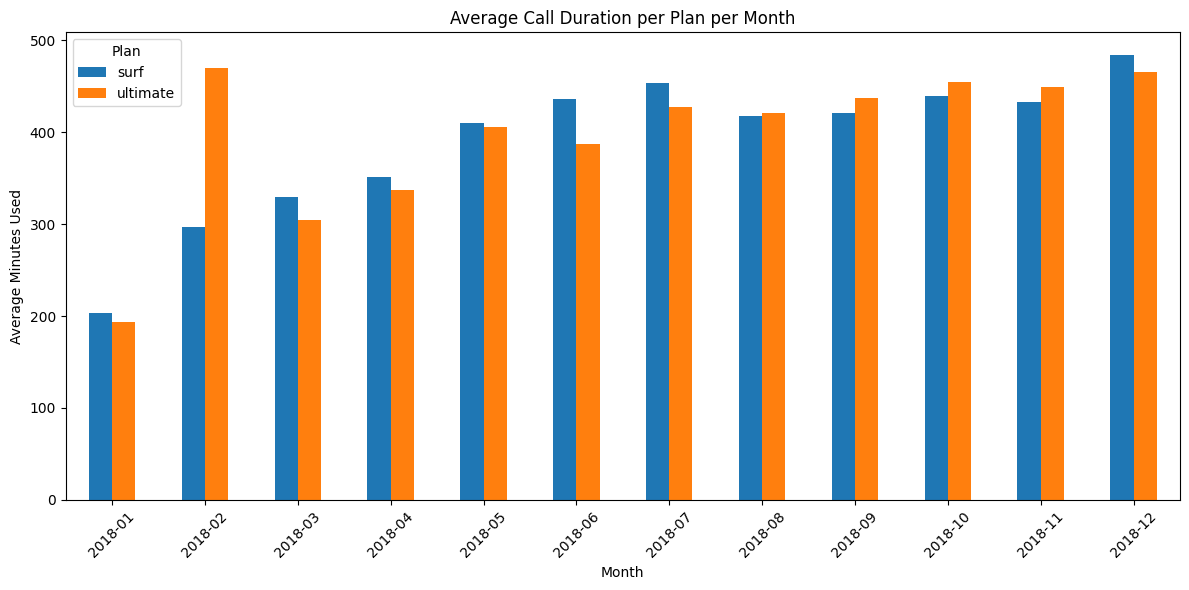

In [27]:
# Compare average duration of calls per each plan per each distinct month. Plot a bar plat to visualize it.

# Calculate average duration of calls per plan per month
avg_duration = (
    monthly.groupby(["month", "plan"])["minutes_used"]
      .mean()
      .reset_index()
)

# Pivot for easier plotting (months as x-axis, plans as separate bars)
pivot_table = avg_duration.pivot(index="month", columns="plan", values="minutes_used")

# Plot
pivot_table.plot(kind="bar", figsize=(12,6))

plt.title("Average Call Duration per Plan per Month")
plt.xlabel("Month")
plt.ylabel("Average Minutes Used")
plt.xticks(rotation=45)
plt.legend(title="Plan")
plt.tight_layout()
plt.show()

**Observations**
User behavior is similar across plans. Having more included minutes in "ultimate" didn’t drastically change calling habits.

February stands out as unusual 

Regardless of plan, customers used more minutes as the year went on. Could suggest higher engagement, more reliance on phones, or simply growth in customer base.

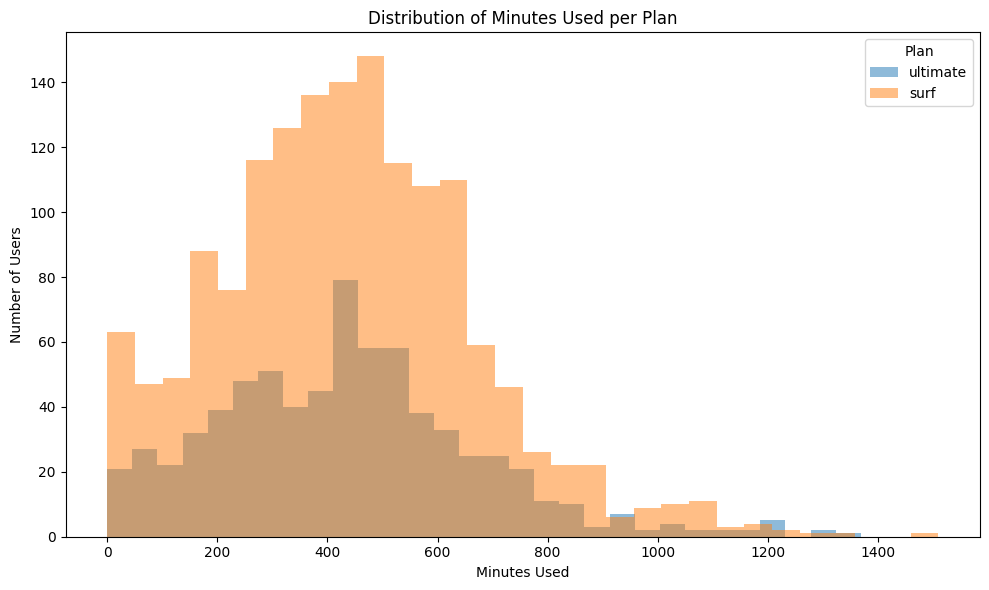

In [28]:
# Compare the number of minutes users of each plan require each month. Plot a histogram.

# Plot histogram of minutes_used, split by plan
plt.figure(figsize=(10,6))

for plan in monthly['plan'].unique():
    subset = monthly[monthly['plan'] == plan]
    plt.hist(subset['minutes_used'], bins=30, alpha=0.5, label=plan)

plt.title("Distribution of Minutes Used per Plan")
plt.xlabel("Minutes Used")
plt.ylabel("Number of Users")
plt.legend(title="Plan")
plt.tight_layout()
plt.show()


**Observations**

Both plans peak around 450 minutes. 

There are more surf users than ultimate users.

In [29]:
# Calculate the mean and the variance of the monthly call duration

call_stats = (
    monthly.groupby("plan")["minutes_used"]
      .agg(["mean", "var"])
      .reset_index()
)

print(call_stats)


       plan        mean           var
0      surf  436.519741  52571.063243
1  ultimate  434.676017  56573.632247


<Figure size 800x600 with 0 Axes>

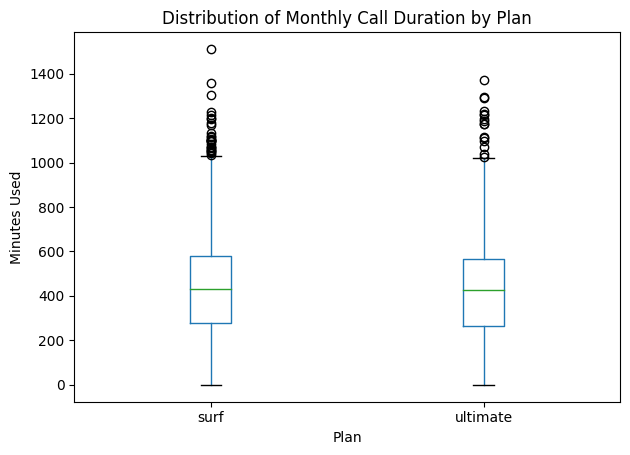

In [30]:
# Plot a boxplot to visualize the distribution of the monthly call duration

plt.figure(figsize=(8,6))

monthly.boxplot(column="minutes_used", by="plan", grid=False)

plt.title("Distribution of Monthly Call Duration by Plan")
plt.suptitle("")  # set to empty 
plt.xlabel("Plan")
plt.ylabel("Minutes Used")
plt.tight_layout()
plt.show()


**Observations**
Both plans look very similar in median (~400 min) and spread.

There are lots of outliers above 1000 min, heavy callers, much higher than the “typical” range.

Surf and ultimate both have outliers, so extreme usage isn’t tied to one plan.

### Messages

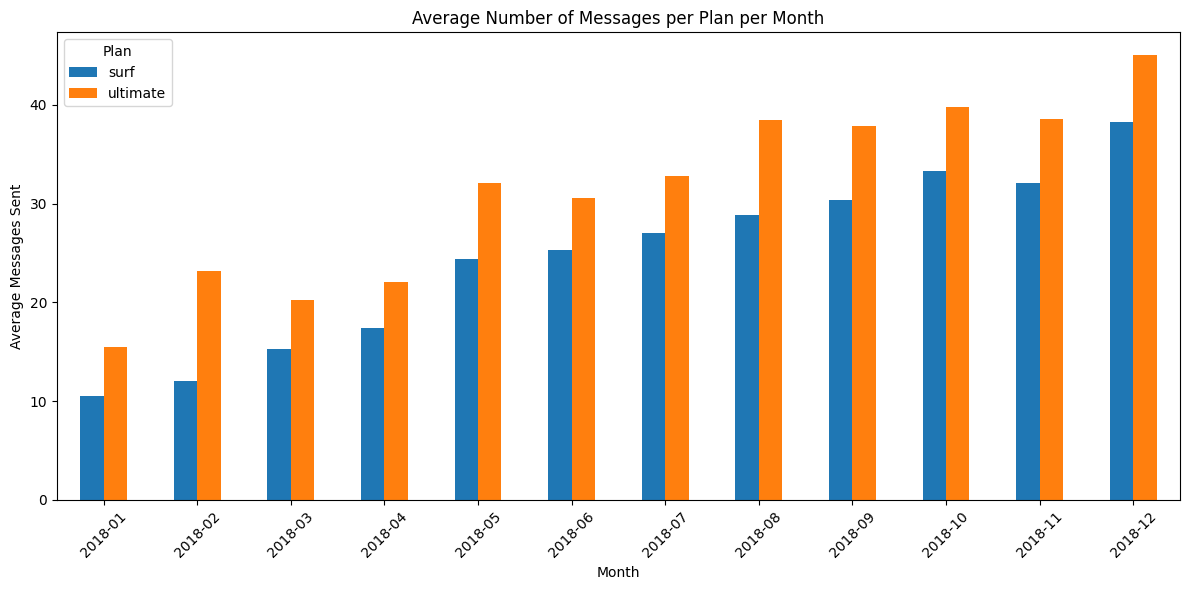

In [31]:
# Compare the number of messages users of each plan tend to send each month

avg_messages = (
    monthly.groupby(["month", "plan"])["messages_sent"]
      .mean()
      .reset_index()
)

# 2. Pivot to make months x-axis, plans as separate bars
pivot_table = avg_messages.pivot(index="month", columns="plan", values="messages_sent")

# 3. Plot bar chart
pivot_table.plot(kind="bar", figsize=(12,6))

plt.title("Average Number of Messages per Plan per Month")
plt.xlabel("Month")
plt.ylabel("Average Messages Sent")
plt.xticks(rotation=45)
plt.legend(title="Plan")
plt.tight_layout()
plt.show()

**Observations**

Both plans show steady growth in average messages sent per month across 2018.

The ultimate plan is consistently higher than surf.

The gap is visible from the beginning (about 15 vs 25 in January) and remains through December ( about 38 vs 45). This suggests that ultimate users send more messages on average.

Surf users nearly quadrupled from ~10 to ~38. Ultimate users almost doubled from ~25 to ~45.

The rate of growth is actually sharper for surf, but ultimate remains ahead throughout.

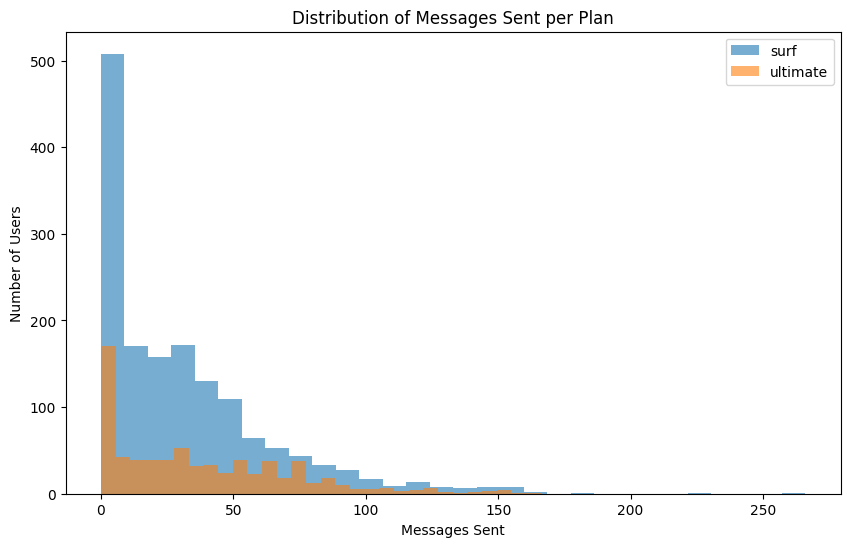

In [32]:
# Messages sent per plan

# Separate the data
surf_msgs = monthly[monthly['plan'] == 'surf']['messages_sent']
ult_msgs = monthly[monthly['plan'] == 'ultimate']['messages_sent']

plt.figure(figsize=(10,6))
plt.hist(surf_msgs, bins=30, alpha=0.6, label='surf')
plt.hist(ult_msgs, bins=30, alpha=0.6, label='ultimate')
plt.title("Distribution of Messages Sent per Plan")
plt.xlabel("Messages Sent")
plt.ylabel("Number of Users")
plt.legend()
plt.show()

**Observations**

Most customers don’t rely heavily on texting (maybe they prefer calls or data-based messaging apps).

Ultimate users show a higher share of people sending 50+ messages, which suggests that having more included messages (or unlimited) encourages heavier texting.

Surf could generate more overage fees from the small group of heavier texters

<Figure size 800x600 with 0 Axes>

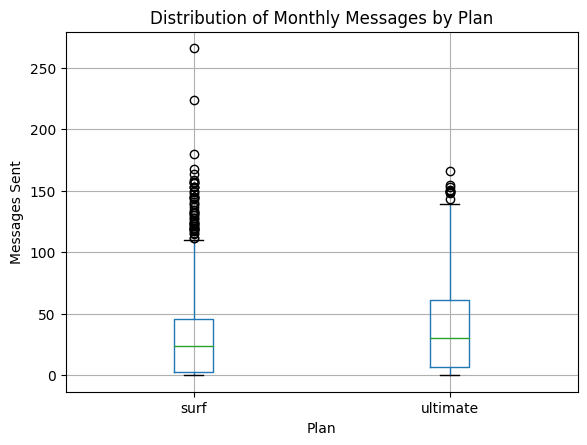

In [33]:
# Compare messages by plan box chart

plt.figure(figsize=(8,6))
monthly.boxplot(column='messages_sent', by='plan')
plt.title("Distribution of Monthly Messages by Plan")
plt.suptitle("")  # remove default subtitle
plt.xlabel("Plan")
plt.ylabel("Messages Sent")
plt.show()

**Observations**

Surf median: ~15 messages/month vs Ultimate median: ~25–30 messages/month. So ultimate users send more messages on average.

Many outliers exist for both plans, especially above 100–150 messages.

Outliers are more common in surf likely because some users exceed their limited allowance.

### Internet

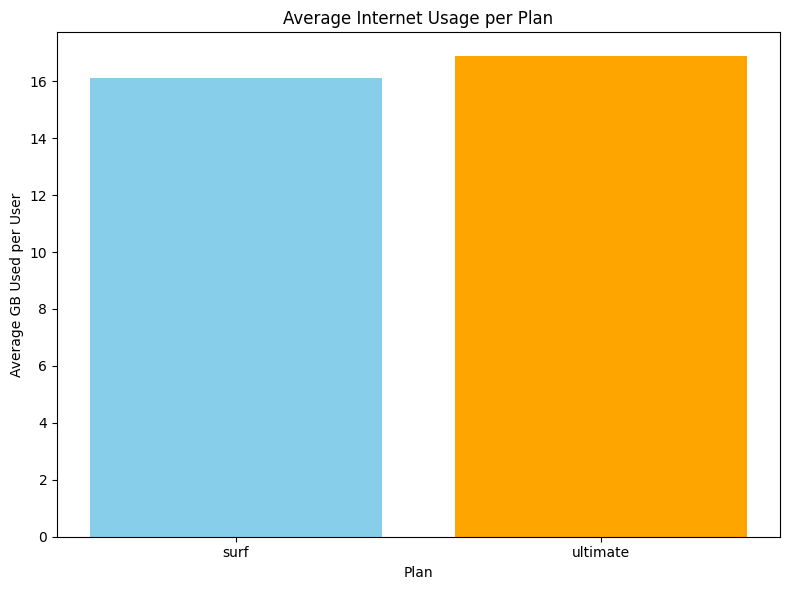

In [34]:
# Compare the amount of internet traffic consumed by users per plan

avg_internet = (
    monthly.groupby("plan")["gb_used"]
      .mean()
      .reset_index()
)

plt.figure(figsize=(8,6))
plt.bar(avg_internet["plan"], avg_internet["gb_used"], color=["skyblue", "orange"])
plt.title("Average Internet Usage per Plan")
plt.xlabel("Plan")
plt.ylabel("Average GB Used per User")
plt.tight_layout()
plt.show()

**Observations**
Surf users: ~16 GB/month. Ultimate users: ~17 GB/month. The difference is small — ultimate users consume only slightly more.
Unlike SMS, where ultimate clearly drove higher usage, internet traffic seems to be less affected by the plan.

Surf users are in average paying extra for internet each month 

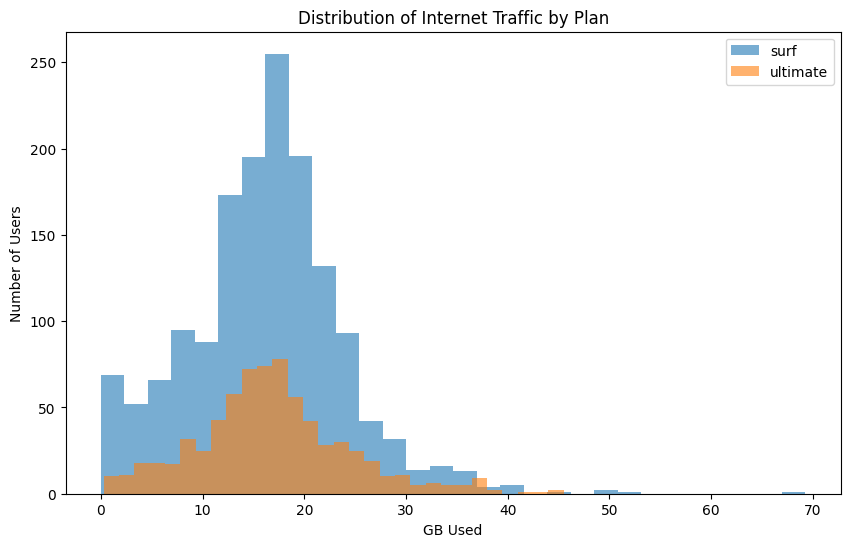

In [35]:
#Compare GB user per plan

surf_data = monthly[monthly['plan'] == 'surf']['gb_used']
ult_data = monthly[monthly['plan'] == 'ultimate']['gb_used']

plt.figure(figsize=(10,6))
plt.hist(surf_data, bins=30, alpha=0.6, label='surf')
plt.hist(ult_data, bins=30, alpha=0.6, label='ultimate')
plt.title("Distribution of Internet Traffic by Plan")
plt.xlabel("GB Used")
plt.ylabel("Number of Users")
plt.legend()
plt.show()

**Observations**

Big spike right around 15–16 GB. Many Surf users are hitting (and exceeding) the cap, which means they’re paying overage fees

They use similar amounts of data on average, but are well under the 30 GB allowance.

That means most ultimate customers are comfortably within their plan, rarely paying overages.

Both Surf and Ultimate have outliers up to 40+ GB, even 60–70 GB.

These heavy data users would rack up significant overage charges on Surf, but Ultimate absorbs much of it (cheaper overages and higher allowance).

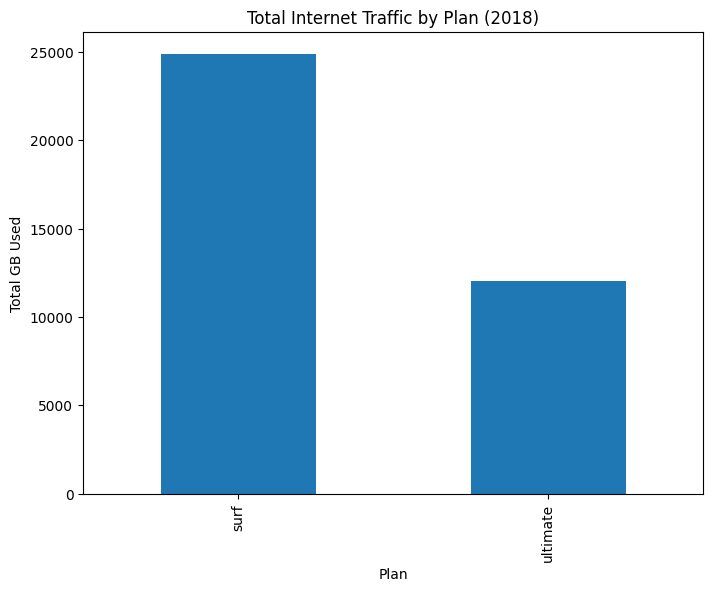

In [36]:
#Total internet traffic per plan
total_data = monthly.groupby('plan')['gb_used'].sum()

total_data.plot(kind='bar', figsize=(8,6))
plt.title("Total Internet Traffic by Plan (2018)")
plt.xlabel("Plan")
plt.ylabel("Total GB Used")
plt.show()

**Observations**

Surf users consumed about 25,000 GB total. Ultimate users consumed about 12,000 GB total.

Surf customers used roughly double the amount of internet traffic compared to Ultimate customers. This isn’t because Surf users are heavier internet consumers individually, It’s because there are more Surf customers than Ultimate customers in the dataset.



## Revenue

[Likewise you have studied the user behaviour, statistically describe the revenue between the plans.]

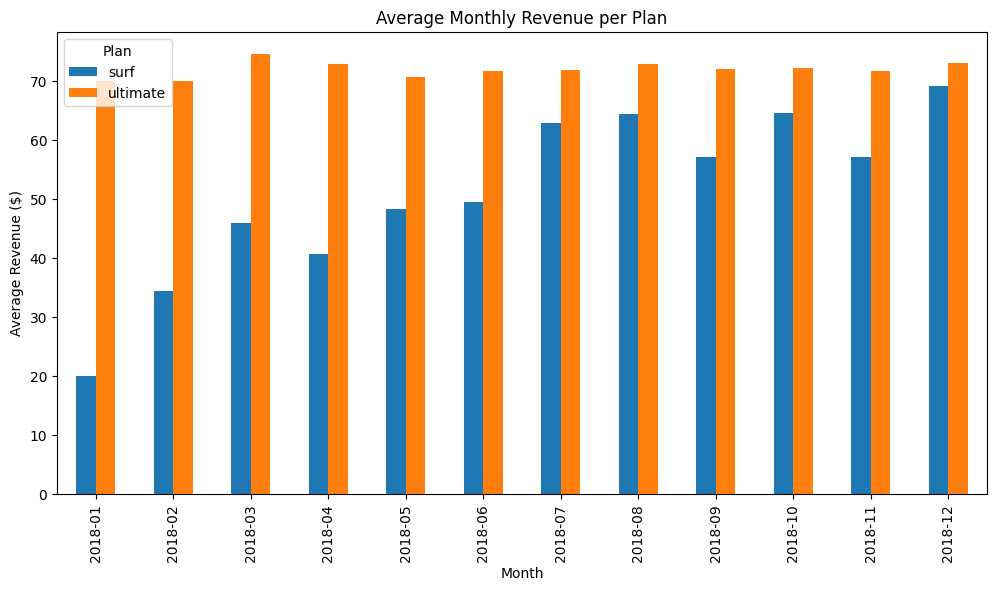

In [37]:
# Compare average montly revenue per plan

avg_rev = monthly.groupby(['month','plan'])['revenue'].mean().unstack()

avg_rev.plot(kind='bar', figsize=(12,6))
plt.title("Average Monthly Revenue per Plan")
plt.xlabel("Month")
plt.ylabel("Average Revenue ($)")
plt.legend(title="Plan")
plt.show()

**Observations**

Ultimate: Stays very steady around $70–74 across all months

Surf: Starts low (~$20 in Jan) but steadily climbs across the year to ~70 by December.

By the end of the year, Surf’s average revenue per user is nearly equal to Ultimate.

The difference is that Surf revenue is volatile and unpredictable, while Ultimate is flat and reliable.

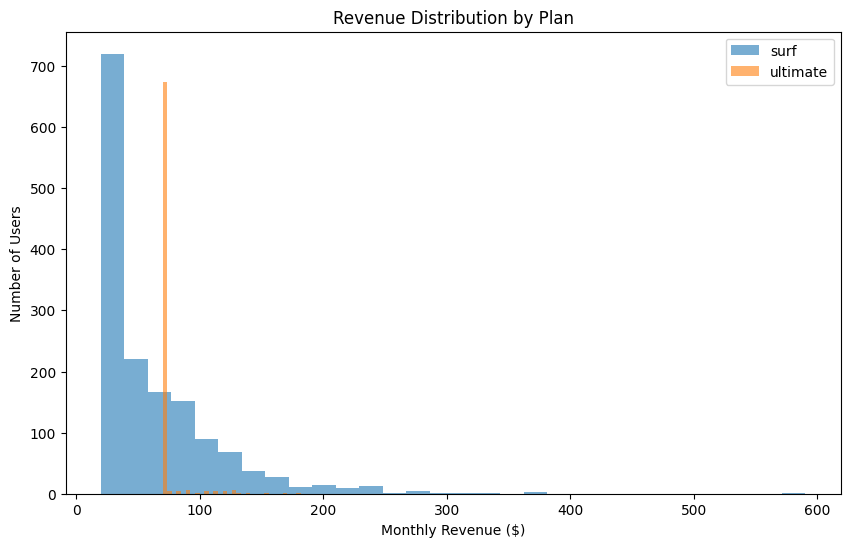

In [38]:
#Revenue distribution
surf_rev = monthly[monthly['plan'] == 'surf']['revenue']
ult_rev  = monthly[monthly['plan'] == 'ultimate']['revenue']

plt.figure(figsize=(10,6))
plt.hist(surf_rev, bins=30, alpha=0.6, label='surf')
plt.hist(ult_rev, bins=30, alpha=0.6, label='ultimate')
plt.title("Revenue Distribution by Plan")
plt.xlabel("Monthly Revenue ($)")
plt.ylabel("Number of Users")
plt.legend()
plt.show()

**Observations**

Surf: Spike at $20 for users who stayed within their plan limits. Long tail stretching to the right. Due to the overages. 

Ultimate: Almost all Ultimate users are tightly clustered around $70–75, one bin for the most part and very little variation compared to Surf.

## Test statistical hypotheses

We will use Welch's t-test (two-sided) for mean comparisons because group variances and sizes differ.

Let ( \alpha = 0.05 ).

Plans:

1) Plan comparison (Surf vs Ultimate)

Question: “Does average monthly revenue differ between Surf and Ultimate users?”

Null (H₀): μ_surf = μ_ultimate (no difference in mean revenue)

Alt (H₁): μ_surf ≠ μ_ultimate (means differ)

Region (NY-NJ vs others):

2) Region comparison (NY–NJ vs other regions)

Question: “Does average monthly revenue differ between NY–NJ users and everyone else?”

Null (H₀): μ_NY-NJ = μ_other

Alt (H₁): μ_NY-NJ ≠ μ_other

In [39]:
# Test the hypotheses plans
def welch_ci(mean1, var1, n1, mean2, var2, n2, alpha=0.05):
    """95% CI (by default) for the difference in means: mean1 - mean2"""
    se = np.sqrt(var1/n1 + var2/n2)
    # Welch–Satterthwaite df
    df = (var1/n1 + var2/n2)**2 / ((var1**2)/((n1**2)*(n1-1)) + (var2**2)/((n2**2)*(n2-1)))
    tcrit = stats.t.ppf(1 - alpha/2, df)
    diff = mean1 - mean2
    return diff, diff - tcrit*se, diff + tcrit*se, df

# Surf Vs Ultimate
surf = monthly.loc[monthly['plan'] == 'surf', 'revenue'].dropna()
ultimate = monthly.loc[monthly['plan'] == 'ultimate', 'revenue'].dropna()

t_stat, p_val = stats.ttest_ind(surf, ultimate, equal_var=False)

m1, v1, n1 = surf.mean(), surf.var(ddof=1), surf.shape[0]
m2, v2, n2 = ultimate.mean(), ultimate.var(ddof=1), ultimate.shape[0]
diff, lo, hi, df = welch_ci(m1, v1, n1, m2, v2, n2, alpha=0.05)

print("Surf vs Ultimate (Welch t-test)")
print(f"n_surf={n1}, n_ultimate={n2}")
print(f"mean_surf=${m1:0.2f}, mean_ultimate=${m2:0.2f}")
print(f"mean_diff = mean_surf - mean_ultimate = {diff:0.2f}")
print(f"95% CI for diff: [{lo:0.2f}, {hi:0.2f}]  (df≈{df:0.1f})")
print(f"t={t_stat:0.3f}, p-value={p_val:0.4g}")


Surf vs Ultimate (Welch t-test)
n_surf=1545, n_ultimate=713
mean_surf=$60.11, mean_ultimate=$72.28
mean_diff = mean_surf - mean_ultimate = -12.17
95% CI for diff: [-14.97, -9.37]  (df≈1822.2)
t=-8.533, p-value=2.953e-17


**Observation**
At α = 0.05 (and even stricter α = 0.01 or Bonferroni α = 0.025), we reject the null hypothesis.

There is strong evidence that the average revenue differs between Surf and Ultimate plans.

Practically: Ultimate generates about $12 more revenue per user on average.

In [40]:
# Test the hypotheses Cities

# Define NY–NJ users. 
ny_nj_mask = monthly['city'].str.contains(r'NY|New York|Jersey|NJ', case=False, na=False)

# Find 
ny_nj = monthly.loc[ny_nj_mask, 'revenue'].dropna()
other = monthly.loc[~ny_nj_mask, 'revenue'].dropna()

t_stat2, p_val2 = stats.ttest_ind(ny_nj, other, equal_var=False)

m1b, v1b, n1b = ny_nj.mean(), ny_nj.var(ddof=1), ny_nj.shape[0]
m2b, v2b, n2b = other.mean(), other.var(ddof=1), other.shape[0]
diff2, lo2, hi2, df2 = welch_ci(m1b, v1b, n1b, m2b, v2b, n2b, alpha=0.05)

print("\nNY–NJ vs Other Regions (Welch t-test)")
print(f"n_ny_nj={n1b}, n_other={n2b}")
print(f"mean_ny_nj=${m1b:0.2f}, mean_other=${m2b:0.2f}")
print(f"mean_diff = mean_ny_nj - mean_other = {diff2:0.2f}")
print(f"95% CI for diff: [{lo2:0.2f}, {hi2:0.2f}]  (df≈{df2:0.1f})")
print(f"t={t_stat2:0.3f}, p-value={p_val2:0.4g}")


NY–NJ vs Other Regions (Welch t-test)
n_ny_nj=506, n_other=1752
mean_ny_nj=$61.49, mean_other=$64.66
mean_diff = mean_ny_nj - mean_other = -3.17
95% CI for diff: [-7.63, 1.29]  (df≈819.9)
t=-1.394, p-value=0.1638


**Observations**

At α = 0.05 (and stricter α = 0.025 with Bonferroni correction), the p-value is much larger than alpha.

We fail to reject the null hypothesis.

There is no statistical evidence that average revenue differs between NY–NJ users and users from other regions.

Practically: While NY–NJ users spent about $3 less on average, the variation is large enough that this difference could easily be due to chance.

## General conclusion

Calls: Similar usage across plans, not a major revenue driver.

Messages: Ultimate users send more, but Surf outliers generate extra fees.

Internet: The strongest differentiator. Surf users often exceed their cap, leading to higher but volatile revenue, while Ultimate users stay under their larger cap.

Revenue: Surf starts cheap but climbs with overages; Ultimate is expensive but predictable.

Hypotheses:

Plan choice does affect revenue. Ultimate over Surf.

Region does not affect revenue.

Final takeaway:
The company earns higher, stable revenue from Ultimate users, but Surf users contribute significantly through data overages. For customer satisfaction, Surf risks “bill shock,” while Ultimate offers peace of mind. From a business perspective, both plans are profitable, but in different ways: Surf through unpredictable overage fees, and Ultimate through consistent subscription revenue.